1. fetch patch embeddings of a single patch from a WSI
2. generate 2 (more later) augmentations of this embedding
3. get the absolute difference of each dimension in the augmentations
4. sum each row into different buckets
5. get distribution for the differences of each dimension
6. normalise distribution between 0 and 1
7. plot on histogram
8. repeat 10 times

In [13]:
import os
import torch
import numpy as np

import cv2
import h5py
import matplotlib.pyplot as plt
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

from augmentations.augmentations import aug_combined, aug_rotation


In [14]:
slide_dir = "/media/disk2/prostate/SICAPv2/wsis"
data_root = "/media/disk2/proj_embedding_aug"
extracted_dir = "extracted_mag40x_patch256_fp"
patches_path = os.path.join(data_root, extracted_dir, "patches")

PATCH_SIZE = 256

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

torch.autograd.set_grad_enabled(False)

In [15]:
from torchvision import transforms
from utils.resnet_custom import resnet50_baseline

def eval_transforms(pretrained=False):
    if pretrained:
        mean = (0.485, 0.456, 0.406)
        std = (0.229, 0.224, 0.225)

    else:
        mean = (0.5, 0.5, 0.5)
        std = (0.5, 0.5, 0.5)

    trnsfrms_val = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize(mean=mean, std=std)]
    )

    return trnsfrms_val

model = resnet50_baseline(pretrained=True)
model.to(device)
model.eval()

roi_transforms = eval_transforms(pretrained=True)



In [16]:
def load_patch_img(slide_path, h5_path, patch_size=256, patch_index=0):
    with h5py.File(h5_path, "r") as f:
        patch_coords = f["coords"][()]
        x, y = patch_coords[patch_index]

        slide = Image.open(slide_path)
        slide.load()
        
        image = slide.crop((x, y, x + patch_size, y + patch_size))
        image.load()

        image = np.array(image)

        return image

def get_patch_embs(patch_img):
    patch_img = roi_transforms(patch_img).unsqueeze(0)
    patch_img = patch_img.to(device)

    patch_embs = model(patch_img)
    return patch_embs

def generate_augmentation(patch_embs, aug):
    aug_embs = aug(patch_embs)
    return aug_embs

def get_distribution(aug_a, aug_b):
    distribution = []
    # sum absolute differences for each dimension
    abs_diff = torch.abs(torch.sub(aug_a, aug_b))

    # normalise distribution between 0 and 1
    distribution = abs_diff
    distribution -= distribution.min()
    distribution /= distribution.max()

    return distribution

In [17]:
def get_distribution_for_patch(slide_id, patch_index, aug):
    slide_path = os.path.join(slide_dir, slide_id + ".png")
    h5_path = os.path.join(patches_path, slide_id + "_patches.h5")

    patch_img = load_patch_img(slide_path, h5_path, patch_size=256, patch_index=0)
    patch_embs = get_patch_embs(patch_img)

    a = generate_augmentation(patch_img, aug_combined)
    aug_a = get_patch_embs(a)

    b = generate_augmentation(patch_img, aug_combined)
    aug_b = get_patch_embs(b)

    # print(patch_img.shape)
    # print(patch_embs)
    print(a.shape)
    print(aug_a)
    print(b.shape)
    print(aug_b)

    distribution = get_distribution(aug_a, aug_b)
    print(distribution)
    print(torch.max(distribution))
    print(torch.min(distribution))

    return distribution



(256, 256, 3)
tensor([[0.0979, 0.0174, 0.0175,  ..., 0.0297, 0.0098, 0.0255]],
       device='cuda:0')
(256, 256, 3)
tensor([[0.0906, 0.0354, 0.0201,  ..., 0.0398, 0.0063, 0.0372]],
       device='cuda:0')
tensor([[0.0114, 0.0282, 0.0040,  ..., 0.0158, 0.0055, 0.0185]],
       device='cuda:0')
tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
(256, 256, 3)
tensor([[0.0963, 0.0185, 0.0205,  ..., 0.0295, 0.0132, 0.0161]],
       device='cuda:0')
(256, 256, 3)
tensor([[0.1012, 0.0170, 0.0126,  ..., 0.0283, 0.0121, 0.0252]],
       device='cuda:0')
tensor([[0.0291, 0.0089, 0.0465,  ..., 0.0072, 0.0065, 0.0542]],
       device='cuda:0')
tensor(1., device='cuda:0')
tensor(0., device='cuda:0')
(256, 256, 3)
tensor([[0.0909, 0.0398, 0.0439,  ..., 0.0133, 0.0081, 0.0103]],
       device='cuda:0')
(256, 256, 3)
tensor([[0.0877, 0.0272, 0.0101,  ..., 0.0296, 0.0086, 0.0363]],
       device='cuda:0')
tensor([[0.0085, 0.0343, 0.0916,  ..., 0.0442, 0.0013, 0.0704]],
       device='cuda:0')
ten

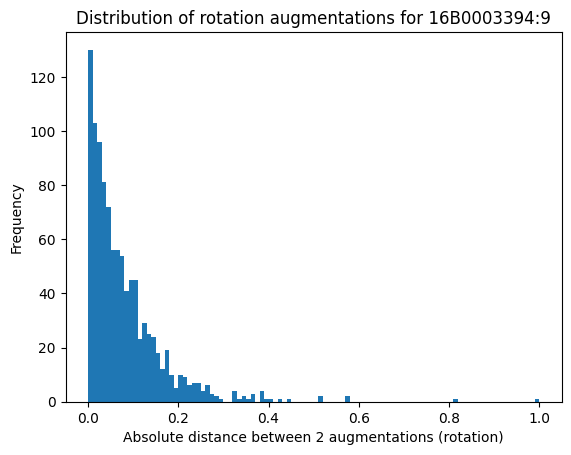

In [18]:
import matplotlib.pyplot as plt
from torch import Tensor

save_dir = "graphs"

aug_fns = {
    "combined": aug_combined,
    "rotation": aug_rotation
}

aug_key = "rotation"
slide_id = "16B0003394"

# plot histograms
n_bins = 100

# reset the plot configurations to default
plt.rcdefaults()
# set the axes color glbally for all plots
plt.rcParams.update({'axes.facecolor':'white'})

for i in range(10):
    distribution = get_distribution_for_patch(slide_id, patch_index=i, aug=aug_fns[aug_key])
    dist_copy = Tensor.cpu(distribution)

    plt.clf()
    plt.title(f"Distribution of {aug_key} augmentations for {slide_id}:{i}")
    plt.xlabel(f"Absolute distance between 2 augmentations ({aug_key})")
    plt.ylabel("Frequency")
    plt.hist(dist_copy, bins=n_bins)
    plt.savefig(os.path.join(save_dir, f"{aug_key}_{i}.png"))
